# Gaussian mechanism PLRV

By [Armaan Bhojwani](https://armaanb.net) under [Praneeth Vepakomma](https://praneeth.mit.edu/)

### Preface
This notebook features the following differentially private operations utilizing [Google's Differential Privacy Accounting library](https://github.com/google/differential-privacy/tree/main/python).

- Gaussian mechanism
    - Privacy loss random variable
    - Privacy loss distribution
    - Observations 1, 2, 3 from [Google Privacy Loss Distributions paper](https://github.com/google/differential-privacy/blob/main/common_docs/Privacy_Loss_Distributions.pdf)

### Dependencies
- dp_accounting
- matplotlib
- scipy
- tqdm

This notebook makes extensive use of Google's `dp_accounting` library. To install, obtain the [sources here](https://github.com/google/differential-privacy/tree/main/python) or from the included git submodule (the submodule is in the `External/` directory, and the sources are in the `External/python/dp_accounting` subdirectory), and install using setuptools (`python3 setup.py install`).

### References
- https://programming-dp.com/ch6.html
- https://desfontain.es/privacy/almost-differential-privacy.html
- https://desfontain.es/privacy/gaussian-noise.html
- https://github.com/google/differential-privacy/tree/main/python
- https://github.com/google/differential-privacy/blob/main/common_docs/Privacy_Loss_Distributions.pdf

    
### Status
- Complete

## Setup

`epsilon` and `delta` are the standard DP parameters. `sensitivity` is the sensitivity of the particular function that you want to test. See [Programming Differential Privacy Chapter 5](https://programming-dp.com/ch5.html#calculating-sensitivity)

### Parameters

In [1]:
epsilon = 3     # Privacy level
delta = 10e-7   # Probability of failure. Should be much less than (length of dataset)^-1
sensitivity = 2 # Sensitivity of function

### Imports

In [2]:
from dp_accounting.pld import privacy_loss_distribution as pld
from dp_accounting.pld import privacy_loss_mechanism as plm

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from math import e
import math

## Privacy loss analysis
### Fitting sigma

The `dp_accounting` library expects you to provide the sensitivity of the function and the standard deviation of the gaussian mechanism to use. This doesn't help us much as we would like to work the other way around, providing the sensitivity of the mechanism, and our privacy tolerances (epsilon and delta) and let the algorithm choose the best standard deviation to use. This function finds the optimal standard deviation to use in the gaussian function while satisfying the given privacy parameters.

A potential replacement for this function is the `calibrate_dp_mechanism` function from the dp_accounting library.

In [3]:
def fit_sigma_from_params(delta, epsilon, sensitivity, verbose=False):
    """ Find the ideal sigma value given privacy parameters.
    
    This function iteratively increases the standard deviation of a gaussian
    PLD until it finds a value that creates a PLD that meets the given privacy
    parameters. It takes a first pass refining until it validates epsilon, 
    then it takes a second pass for delta.
    
    A potential replacement for this function is the calibrate_dp_mechanism
    function from the dp_accounting library.
    
    Inputs:
        delta: delta value to use
        epsilon: epsilon value to use
        sensitivity: sensitivity of mechanism
        
    Output:
        Optimal standard deviation of the gaussian mechanism
    """

    def find_epsilon(sigma, delta, sensitivity):
        gauss_pld = pld.from_gaussian_mechanism(
            sigma, sensitivity=sensitivity, value_discretization_interval=0.01)
        epsilon = gauss_pld.get_epsilon_for_delta(delta)
        return epsilon

    def find_delta(sigma, epsilon, sensitivity):
        gauss_pld = pld.from_gaussian_mechanism(
            sigma, sensitivity=sensitivity, value_discretization_interval=0.01)
        epsilon = gauss_pld.get_delta_for_epsilon(epsilon)
        return epsilon

    # While loop fitting epsilon
    sigma = 1
    test_epsilon = 0
    with tqdm() as t:
        while not math.isclose(test_epsilon, epsilon):
            test_epsilon = find_epsilon(sigma, delta, sensitivity)
            epsilon_range = test_epsilon - epsilon
            sigma += (epsilon_range / 4)

            t.update()

    if verbose: print(f"(Epsilon layer) Fit to sigma of: {sigma}")

    # Do-while loop fitting delta
    with tqdm() as t:
        cond = True
        while cond:
            test_delta = find_delta(sigma, epsilon, sensitivity)
            sigma += 10e-8
            cond = test_delta >= delta

            t.update()

    if verbose: print(f"(Delta layer) Fit to sigma of: {sigma}")

    return sigma


# sigma = fit_sigma_from_params(delta, epsilon, sensitivity, verbose=True)

### Privacy loss distribution functions

0it [00:00, ?it/s]

(Epsilon layer) Fit to sigma of: 3.087722833683524


0it [00:00, ?it/s]

(Delta layer) Fit to sigma of: 3.0877230336835235


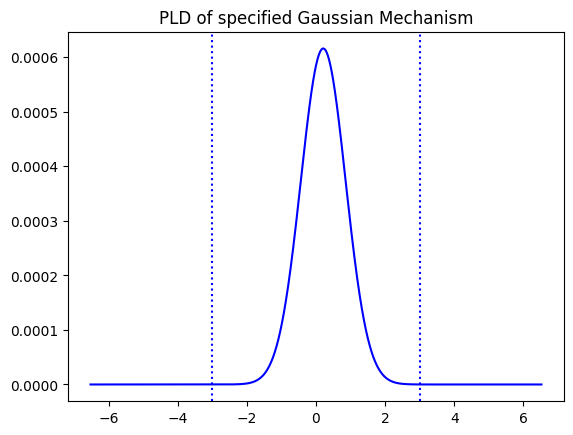

In [4]:
def make_gauss_pld(sigma, sensitivity):
    """ Makes a guassian PLD from standard deviation
    
    Inputs:
        sigma: standard deviation of gaussian mechanism
        sensitivity: sensitivity of mechanism
        
    Output:
        dp_accounting.pld.PrivacyLossDistribution object
    """

    return pld.from_gaussian_mechanism(sigma,
                                       sensitivity=sensitivity,
                                       value_discretization_interval=0.001)


def make_gauss_pld_from_params(delta,
                               epsilon,
                               sensitivity,
                               verbose=False,
                               *args):
    """ Makes a guassian PLD from privacy parameters
    
    Inputs:
        delta: delta value to use
        epsilon: epsilon to use
        sensitivity: sensitivity of mechanism
        
    Output:
        dp_accounting.pld.PrivacyLossDistribution object
    """

    sigma = fit_sigma_from_params(delta, epsilon, sensitivity, verbose=verbose)
    return make_gauss_pld(sigma, sensitivity, *args)


def analyze_gauss_pld(gauss_pld, color='blue', verbose=False):
    """ Create a PMF from a PLD object
    
    Inputs:
        gauss_pld: dp_accounting.pld.PrivacyLossDistribution object
        color: color to use in plots
        verbose: print detail and charts
        
    Output:
        Returns (x, y) PMF of PLD
        If verbose, shows a matplotlib chart of the data
    """
    gauss_pmf = gauss_pld._pmf_add.to_dense_pmf()

    y = gauss_pmf._probs
    y = (y - y.min()) / (y - y.min()).sum()  # Normalize

    x = [gauss_pmf._discretization * gauss_pmf._lower_loss]
    [x.append(gauss_pmf._discretization + x[i - 1]) for i in range(1, len(y))]

    if verbose:
        plt.title(f"PLD of specified Gaussian Mechanism")
        plt.plot(x, y, c=color)
        plt.axvline(epsilon, c=color, linestyle='dotted')
        plt.axvline(-epsilon, c=color, linestyle='dotted')
        plt.show()

    return (x, y)


gauss_pld = make_gauss_pld_from_params(delta,
                                       epsilon,
                                       sensitivity,
                                       verbose=True)
x, y = analyze_gauss_pld(gauss_pld, verbose=True)

### Sampling from the PLD

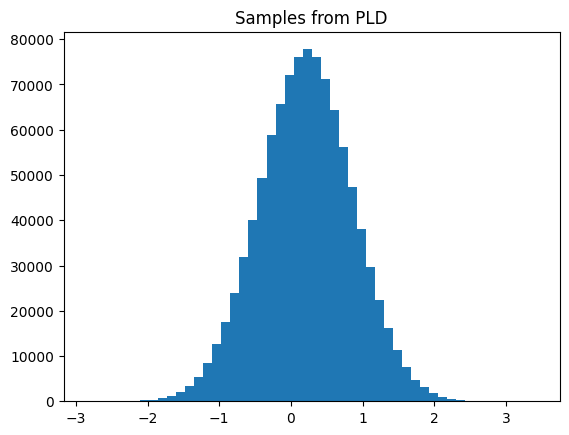

In [5]:
def sample_from_pmf(data, num_samples=1000000, num_bins=50, verbose=False):
    """ Draw samples from a PMF
    
    Inputs:
        data: PMF in the form of (x, y)
        num_samples: number of samples to draw
        num_bins: number of bins to draw in histogram
        verbose: print details and plots
        
    Output:
        array of samples
        If verbose, matplotlib histogram
    """
    rng = np.random.default_rng()
    choices = rng.choice(data[0], num_samples, p=data[1])

    if verbose:
        plt.title("Samples from PLD")
        plt.hist(choices, bins=num_bins)
        plt.show()

    return choices


_ = sample_from_pmf((x, y), verbose=True)

### Google paper observations
Empirical testing of the observations in [this paper](https://github.com/google/differential-privacy/blob/main/common_docs/Privacy_Loss_Distributions.pdf)

#### Observation 1
Epsilon-hockey stick divergence is less than or equal to delta

In [6]:
EHSD = gauss_pld.get_delta_for_epsilon(epsilon)

print(f"Epsilon-Hockey Stick Div: {EHSD}")
print(f"Delta:                    {delta}")
print(f"Observation 1 true?:      {EHSD <= delta}")

Epsilon-Hockey Stick Div: 9.999984507048863e-07
Delta:                    1e-06
Observation 1 true?:      True


#### Observation 2
Epsilon-hockey stick divergence is equal to the given equation

In [7]:
num_samples = 1000000


def observation2(x, y, num_samples=1000000):
    obs = []
    rng = np.random.default_rng()
    samples = rng.choice(x, num_samples, p=y)
    for y in tqdm(samples):
        # eq is the equation given in the paper
        eq = 1 - (e**(epsilon - y))
        obs.append(eq if eq > 0 else 0)

    return np.mean(obs)  # Expected value


obs2 = observation2(x, y, num_samples)
cond = math.isclose(obs2, EHSD, abs_tol=10e-7)

print(f"Obs. 2 result:                 {obs2}")
print(f"Epsilon-Hockey Stick Div:      {EHSD}")
print(f"Obs. 2 true? (result == EHSD): {cond}")

  0%|          | 0/1000000 [00:00<?, ?it/s]

Obs. 2 result:                 1.055938431879598e-06
Epsilon-Hockey Stick Div:      9.999984507048863e-07
Obs. 2 true? (result == EHSD): True


#### Observation 3
Composing mechanisms results in the convolution of their respective PLRVs. In this case, for ease, we self compose the mechanism.

By observation 3, the two histograms should be roughly equal.

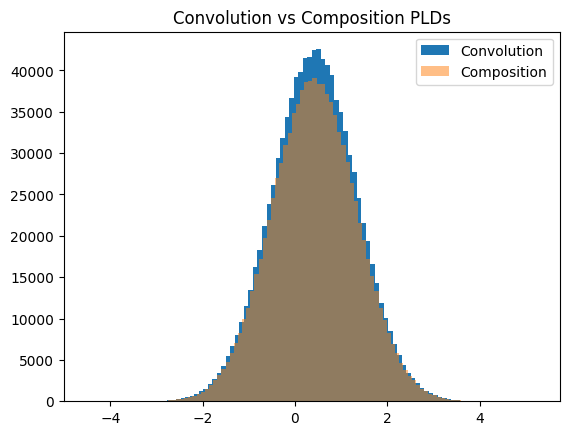

In [8]:
# Convolution (Definition 2)
x1 = sample_from_pmf((x, y)) + sample_from_pmf((x, y))

# Composition
mech2 = gauss_pld.compose(gauss_pld)
x2 = sample_from_pmf(analyze_gauss_pld(mech2))

# They're the same! (Observation 3)
plt.hist(x1, bins=100, label="Convolution")
plt.hist(x2, bins=100, alpha=0.5, label="Composition")
plt.title("Convolution vs Composition PLDs")
plt.legend()
plt.show()